# Installing & Importing Libraries

In [1]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
from keras_cv import bounding_box
from tensorflow import keras
import tensorflow as tf
import keras_cv
import matplotlib.pyplot as plt
import os
from keras_cv import visualization

2024-06-18 15:19:29.155467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 15:19:29.155573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 15:19:29.283198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Data

In [4]:
class_ids = ["car"]
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'car'}

In [8]:
train_image_path = '/kaggle/input/cars-object-detection/train/train/images'
train_label_path = '/kaggle/input/cars-object-detection/train/train/labels'
image_files = os.listdir(train_image_path)
label_files = os.listdir(train_label_path)
image_files.sort()
label_files.sort()
len(image_files),len(label_files)

(234, 234)

In [9]:
img_files_complete_path = []
for image_file in image_files:
    img_files_complete_path.append(os.path.join(train_image_path,image_file))
label_files_complete_path = []
for label_file in label_files:
    label_files_complete_path.append(os.path.join(train_label_path,label_file))
del image_files,label_files

In [10]:
img_files_complete_path[0]

'/kaggle/input/cars-object-detection/train/train/images/01021e5b-GOPR6606.JPG'

## Loading Training Images

In [11]:
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_image_path,
    labels=None,
    batch_size=None,
    shuffle=False,
    image_size=(300, 400),
    color_mode='rgb')
train_images

Found 234 files.


<_PrefetchDataset element_spec=TensorSpec(shape=(300, 400, 3), dtype=tf.float32, name=None)>

### Loading Images as Numpy Array

In [12]:
train_images=np.array(list(train_images.as_numpy_iterator()))
train_images.shape

(234, 300, 400, 3)

## Splitting the Data into Training & Validation Set

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_images,label_files_complete_path,shuffle=False,random_state=29,test_size=0.2)

## Loading the Bounding Boxes & Returning Images,Boxes as Ragged TF Dataset

In [14]:
def load_dict_dataset(images,path_of_labels):
    def load_labels(all_label_paths):
        boxes_of_all_images = []
        classes_of_all_images = []

        for label_path in all_label_paths:
            boxes_of_one_image = []
            classes_of_one_image = []
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    data = line.strip().split()
                    class_id, center_x, center_y, width, height = map(float, data)  # Convert to float
                    center_x *= 400
                    center_y *= 300
                    width *= 400
                    height *= 300
                    #Converting boxes to KerasCV format
                    box = keras_cv.bounding_box.convert_format(
                        np.array([center_x, center_y, width, height]),
                        image_shape=(300,400,3),
                        source="CENTER_XYWH",
                        target='CENTER_XYWH')

                    boxes_of_one_image.append(box)
                    classes_of_one_image.append(0)

                boxes_of_one_image = np.array(boxes_of_one_image)
                classes_of_one_image = np.array(classes_of_one_image)

                boxes_of_all_images.append(boxes_of_one_image)
                classes_of_all_images.append(classes_of_one_image)

                del boxes_of_one_image, classes_of_one_image  # To clear RAM

        # Convert lists to RaggedTensors and then to regular tensors
        boxes_of_all_images = tf.ragged.constant(boxes_of_all_images)
        classes_of_all_images = tf.ragged.constant(classes_of_all_images)

        return boxes_of_all_images, classes_of_all_images

    boxes, classes = load_labels(path_of_labels)

    # Create image dataset dictionary
    image_dataset = tf.data.Dataset.from_tensor_slices({
            'images': tf.ragged.constant(images),
            'bounding_boxes': {
                'classes': classes,
                'boxes': boxes
        }
    })
    return image_dataset

In [15]:
#Loading training and test data in format suitable for Keras_CV
train_dict_dataset = load_dict_dataset(X_train,y_train).batch(4)
test_dict_dataset = load_dict_dataset(X_test,y_test).batch(4)

## Visualizing the Dataset

In [16]:
def visualize_dataset(inputs, rows, cols, value_range=(0, 255), bounding_box_format='CENTER_XYWH'):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=4,
        font_scale=0,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

### Visualizing Training Dataset

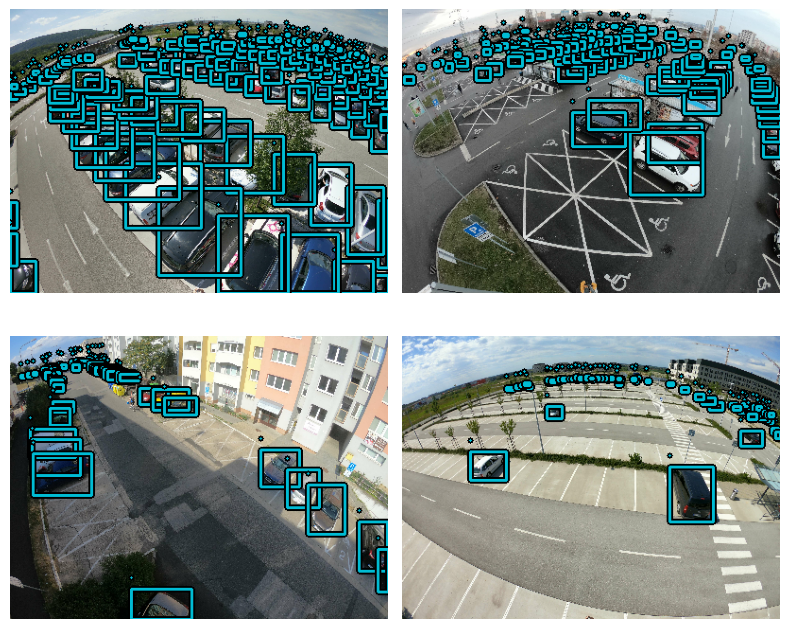

In [17]:
visualize_dataset(train_dict_dataset, rows=2, cols=2, bounding_box_format='CENTER_XYWH')

### Visualizing Validation Dataset

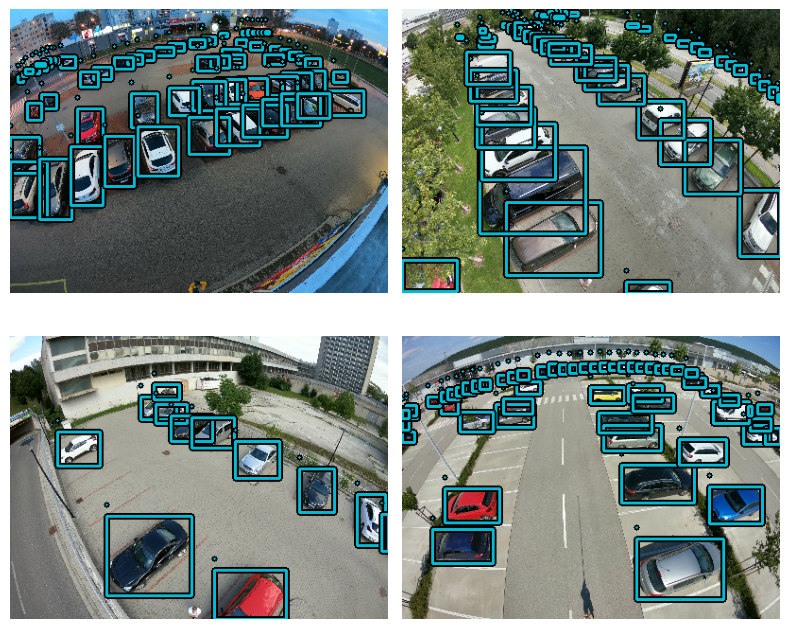

In [ ]:
visualize_dataset(test_dict_dataset, rows=2, cols=2, bounding_box_format='CENTER_XYWH')

# Data Augmentation

### Augmenting & Visualizing Augmented Training Data

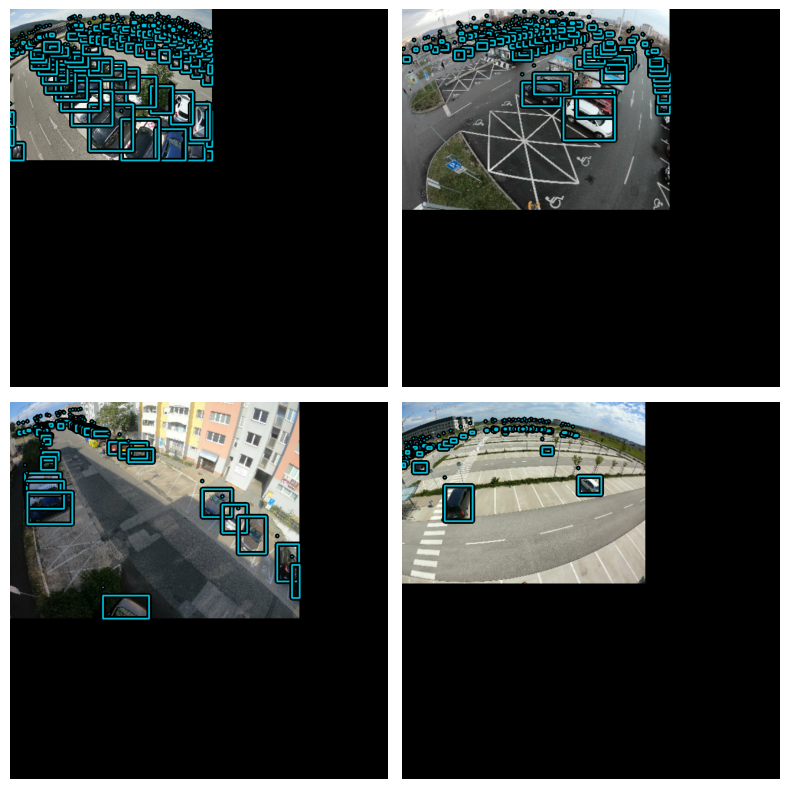

In [19]:
BBOX_FORMAT='CENTER_XYWH'
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=BBOX_FORMAT),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format=BBOX_FORMAT),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_dict_dataset = train_dict_dataset.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(train_dict_dataset, bounding_box_format=BBOX_FORMAT, value_range=(0, 255), rows=2, cols=2)

### Augmenting & Visualizing Augmented Validation Data

In [20]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format=BBOX_FORMAT, pad_to_aspect_ratio=True
)
test_dict_dataset = test_dict_dataset.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

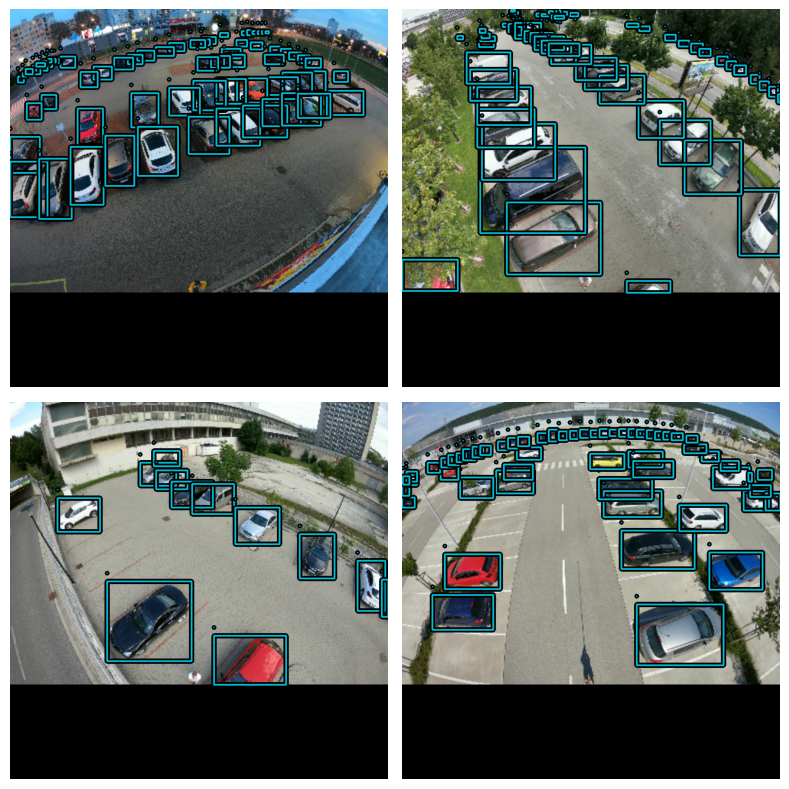

In [21]:
visualize_dataset(test_dict_dataset, bounding_box_format=BBOX_FORMAT, value_range=(0, 255), rows=2, cols=2)

## Converting Dataset to Tuple for Training

In [22]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
    inputs["bounding_boxes"], max_boxes=214)


train_dataset_dict_to_tuple = train_dict_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_dict_to_tuple = test_dict_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Training the Neural Network

## Defining Checkpoints

In [24]:
def visualize_detections(model, dataset, bounding_box_format=BBOX_FORMAT,rows=2,cols=2):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=rows,
        cols=cols,
        show=True,
        font_scale=0,
        class_mapping=class_mapping,
    )

     
checkpoint_path="/kaggle/working/yolo_model_yolo_backbone.keras"

callbacks_list = [
    # Conducting early stopping to stop after 5 epochs of non-improving validation loss
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    ),

    # Saving the best model
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
    ),

    # Incorporate learning rate scheduling
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                         patience=3, min_lr=1e-6),
]



## Creating the model & Training it

In [25]:
tf.keras.backend.clear_session()

def create_model():
    model = keras_cv.models.YOLOV8Detector.from_preset(
        "yolo_v8_m_backbone_coco",
        num_classes=len(class_mapping),
        bounding_box_format=BBOX_FORMAT)
    return model
model = create_model()

# Customizing non-max supression of model prediction. Necessary to fix bug in NonMaxSuppression
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    input_shape=(640,640),
    bounding_box_format=BBOX_FORMAT,
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.5,
)

# Using focal classification loss and smoothl1 box loss with coco metrics
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3,global_clipnorm=10.0),
    jit_compile=False,
)

history = model.fit(
    train_dataset_dict_to_tuple.prefetch(4),
    epochs=60,
    validation_data=test_dataset_dict_to_tuple.prefetch(4),
    batch_size=4,
    callbacks=callbacks_list,
    verbose=1,
)

Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_m_backbone_coco/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_m_backbone_coco/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/yolov8/keras/yolo_v8_m_backbone_coco/2' to your Kaggle notebook...


Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras_cv/src/layers/object_detection/multi_class_non_max_suppression.py:56: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1718724432.221131     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 97s 591ms/step - loss: 183.6488 - val_loss: 16.8949 - learning_rate: 0.0010
Epoch 2/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 392ms/step - loss: 8.3006 - val_loss: 15.0091 - learning_rate: 0.0010
Epoch 3/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - loss: 5.3934 - val_loss: 5.8420 - learning_rate: 0.0010
Epoch 4/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - loss: 4.8325 - val_loss: 5.0018 - learning_rate: 0.0010
Epoch 5/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - loss: 4.5498 - val_loss: 4.8223 - learning_rate: 0.0010
Epoch 6/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - loss: 4.4058 - val_loss: 4.5910 - learning_rate: 0.0010
Epoch 7/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - loss: 4.1247 - val_loss: 4.3545 - learning_rate: 0.0010
Epoch 8/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - loss: 3.9748 - val_loss: 4.5261 - learning_rate: 0.0010
Epoch 9/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - loss: 3.8288 - val_loss: 4.1363 - learning_rate: 0.0010
Epoch 10

## Plotting the Loss Curve

<Axes: >

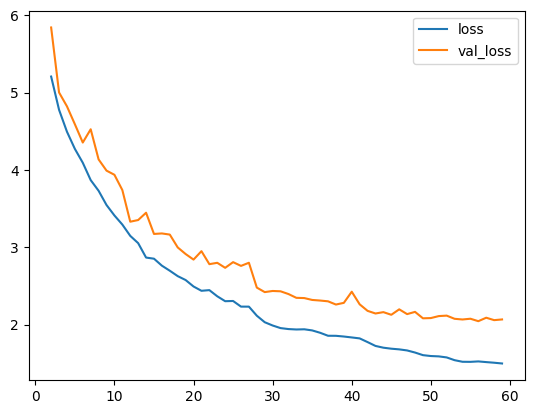

In [27]:
pd.DataFrame(history.history).iloc[2:,:2].plot()

In [33]:
pd.DataFrame(history.history)

loss   val_loss  learning_rate
0   81.681473  76.104973        0.00100
1    9.902327   8.139045        0.00100
2    5.624272   5.314513        0.00100
3    4.850606   4.739009        0.00100
4    4.395263   5.320966        0.00100
5    4.193206   5.054917        0.00100
6    3.954099   4.361725        0.00100
7    3.644964   3.770629        0.00100
8    3.429387   3.742255        0.00100
9    3.295449   3.549500        0.00100
10   3.136621   3.466696        0.00100
11   3.093901   3.346006        0.00100
12   2.839857   3.218002        0.00100
13   2.787988   3.031848        0.00100
14   2.740879   3.058774        0.00100
15   2.662386   3.077431        0.00100
16   2.577741   2.856861        0.00100
17   2.552113   3.031244        0.00100
18   2.513518   2.813845        0.00100
19   2.424323   2.779013        0.00100
20   2.427900   2.668243        0.00100
21   2.338051   2.834991        0.00100
22   2.298977   2.705808        0.00100
23   2.288490   2.558638        0.00100
24   2.199517   2.568409        0.00100
25   2.203575   2.535008        0.00100
26   2.151736   2.563688        0.00100
27   2.124473   2.614795        0.00100
28   2.067713   2.514604        0.00100
29   2.083082   2.419133        0.00100
30   2.035119   2.468108        0.00100
31   2.033928   2.405504        0.00100
32   1.994209   2.542192        0.00100
33   2.001899   2.622004        0.00100
34   1.981600   2.341733        0.00100
35   1.970509   2.418294        0.00100
36   1.987400   2.455133        0.00100
37   1.900033   2.436182        0.00100
38   1.885846   2.292282        0.00050
39   1.842979   2.250640        0.00050
40   1.792586   2.207016        0.00050
41   1.770843   2.199417        0.00050
42   1.741003   2.179395        0.00050
43   1.706879   2.241468        0.00050
44   1.734228   2.165655        0.00050
45   1.725593   2.170178        0.00050
46   1.713988   2.185631        0.00050
47   1.716597   2.167212        0.00050
48   1.653714   2.201764        0.00025
49   1.628376   2.244588        0.00025

## Further Training to Reduce Loss

In [28]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=tf.keras.optimizers.Adam(learning_rate=6.2500e-05,global_clipnorm=10.0),
    jit_compile=False,
)

history_yolo_yolo_m_backbone = model.fit(
    train_dataset_dict_to_tuple.prefetch(4),
    epochs=60,
    validation_data=test_dataset_dict_to_tuple.prefetch(4),
    batch_size=4,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 477ms/step - loss: 1.5871 - val_loss: 2.0639 - learning_rate: 6.2500e-05
Epoch 2/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - loss: 1.5588 - val_loss: 2.0673 - learning_rate: 6.2500e-05
Epoch 3/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - loss: 1.5860 - val_loss: 2.0758 - learning_rate: 6.2500e-05
Epoch 4/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - loss: 1.5682 - val_loss: 2.0654 - learning_rate: 6.2500e-05
Epoch 5/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - loss: 1.5761 - val_loss: 2.0426 - learning_rate: 3.1250e-05
Epoch 6/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - loss: 1.5410 - val_loss: 2.0343 - learning_rate: 3.1250e-05
Epoch 7/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - loss: 1.5564 - val_loss: 2.0377 - learning_rate: 3.1250e-05
Epoch 8/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 386ms/step - loss: 1.5449 - val_loss: 2.0369 - learning_rate: 3.1250e-05
Epoch 9/60
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - loss: 1.5459 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


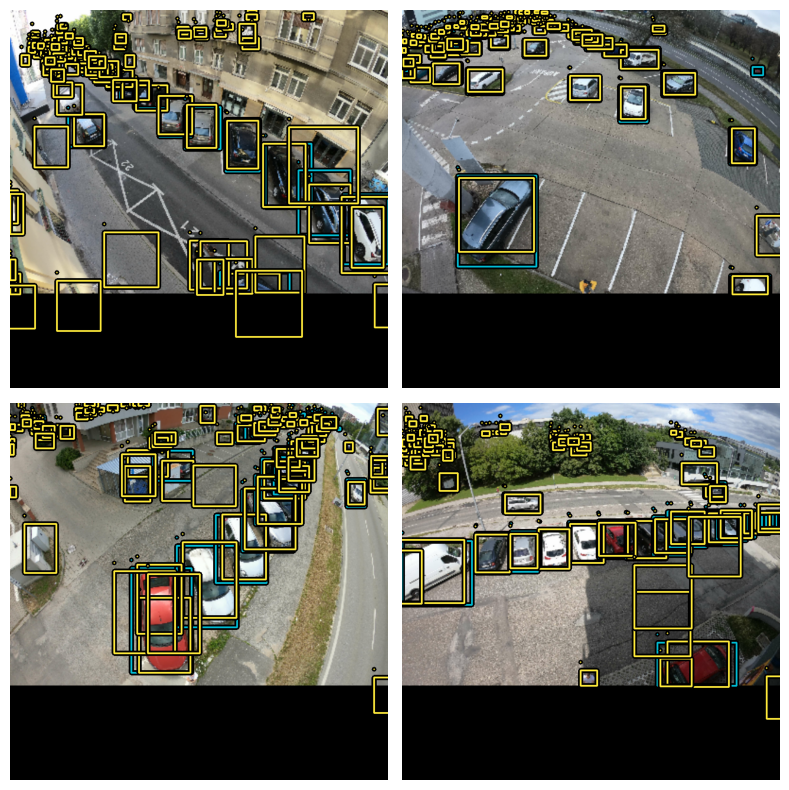

In [30]:
visualize_detections(model,dataset = test_dataset_dict_to_tuple.shuffle(4))

# Loading Test Images & Making Predictions

In [31]:
test_images_path = '/kaggle/input/cars-object-detection/test/test/images'
test_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_images_path,
    labels=None,
    batch_size=None,
    shuffle=False,
    image_size=(640, 640),
    color_mode='rgb')
test_images

Found 59 files.


<_PrefetchDataset element_spec=TensorSpec(shape=(640, 640, 3), dtype=tf.float32, name=None)>

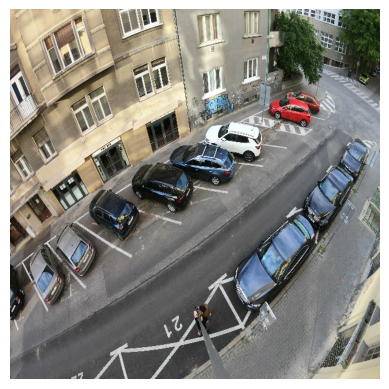

In [32]:
for img in test_images.take(1):
    plt.imshow(img.numpy().astype(np.int16))
    plt.axis('off')

## Extracting Image file Name to make 'id' column

In [33]:
test_images_names = os.listdir(test_images_path)
test_images_names.sort()

#Looping every filename to remove ".jpg" file extension
for k in range(len(test_images_names)):
    img_name,_ = test_images_names[k].split('.')
    test_images_names[k] = img_name
test_images_names[0]

'024cfeb7-GOPR6549'

In [34]:
test_images=np.array(list(test_images.as_numpy_iterator()))
test_images.shape

(59, 640, 640, 3)

## Predicting on Test Images

In [35]:
y_preds_yolo = model.predict(test_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 9s/step


## Converting Predictions into suitable format for Submission

In [36]:
y_pred = y_preds_yolo
predicted_classid, predicted_confidence, predicted_boxes , predicted_num_detections = y_pred['classes'],y_pred['confidence'],y_pred['boxes'], y_pred['num_detections']
ans = []
for i in range(59):#Number of test images i.e. for each image
    tmp=[]
    for j in range(predicted_num_detections[i]):
        tmp.extend([0,predicted_confidence[i,j],predicted_boxes[i,j,0]/640,predicted_boxes[i,j,1]/640,predicted_boxes[i,j,2]/640,predicted_boxes[i,j,3]/640])
    ans.append(tmp)    

In [37]:
submissions=pd.DataFrame({
    'id':test_images_names,
    'predictions':ans
})

In [38]:
submissions.head()

id                                        predictions
0  024cfeb7-GOPR6549  [0, 0.70294404, 0.6056615829467773, 0.35522909...
1  0635aa25-GOPR6590  [0, 0.71269596, 0.11460248231887818, 0.4455518...
2  06a132db-GOPR6571  [0, 0.7095363, 0.382017183303833, 0.1464869379...
3  0758bd59-GOPR6699  [0, 0.7122144, 0.4194496631622314, 0.247983694...
4  0e8671d1-GOPR6626  [0, 0.7042669, 0.6288397312164307, 0.281403708...

In [39]:
submissions.to_csv('/kaggle/working/submissions_yolo.csv',index=False)